#### Decomposable functions

Recall the concept of `gradient descent` is to, at iteration $k$, minimize the quadratic approximation of $f$ at $x^k$

$$x^{k+1}=\arg \min_xf(x^{k})+\nabla f(x^{k})^T(x-x^{k})+\frac{1}{2t^k}\|x-x^{k}\|_2^2$$

We take derivative and set it to zero

$$0+\nabla f(x^{k})+\frac{1}{t^k}(x-x^{k})=0$$

and we get the gradient descent equation

$$x^{k+1}=x^{k}-t^k \nabla f(x^{k})$$

The main motivation of proximal gradient method is that, when $f$ is not differentiable, rather than replacing the whole thing using subgradient, which we have seen is slow, we would like to keep some portion of this quadratic approximation

In particular, we look at function

$$f(x)=g(x)+h(x)$$

where $g$ is differentiable while $h$ is not

and we apply the quadratic approximation to $g$

$$\begin{align*}
x^{k+1} &  = \arg \min_z g(x^k)+\nabla g(x^k)^T(z-x^k)+\frac{1}{2t}\|z-x^k\|_2^2+h(z)\\
& g(x^k), \nabla g(x^k) \text{ as individual term has no effect on minimization over z}\\
 & = \arg \min_z \frac{1}{2} t\|\nabla g(x^k)\|_2^2+\nabla g(x^k)^T(z-x^k)+\frac{1}{2t}\|z-x^k\|_2^2+h(z)\\
&=\arg\min_z\frac{1}{2t}\|z-\left(x^k-t\nabla g(x^k)\right)\|_2^2+h(z)
\end{align*}$$

That is, we try to find a $z$ such that

* it stays close to gradient update of $g$ by minimizing $\|z-\left(x^k-t\nabla g(x^k)\right)\|_2^2$
* it makes $h$ small by minimizing $h(z)$

#### Proximal operator

More formally, we define proximal operator as

$$\text{prox}_{h, t}(x) = \arg \min_z \frac{1}{2t}\|z-x\|_2^2+h(z) $$

(Note the $t$)

As an example, if $h(z)$ is the indicator function, then

$$\begin{align*}
\text{prox}_{I, t}(x) &= \arg \min_z \frac{1}{2t}\|z-x\|_2^2+I_S(z) \\
&=\arg \min_{z\in S} \frac{1}{2t}\|z-x\|_2^2
\end{align*}$$

We see that it is the projection operation $\text{prox}_{I,t}(x)=P_s(x)$

Use proximal operator, we can write proximal gradient step for $f(x)=g(x)+h(x)$

$$x^{k+1} = \text{prox}_{h, t}(x^k-t\nabla g(x^k))$$

or we can write it more like standard gradient step by defining

$$G_t(x)=\left(x-\text{prox}_{h, t}\left(x-t\nabla g(x)\right)\right)/t$$

which is often called generalized gradient of $f$

With this, we can write the proximal gradient step as

$$x^{k+1}=x^k-tG_{t}(x^k)$$

The key point for proximal method is that
* $\text{prox}_{h, t}(\cdot)$ often has `closed-form` expression for many commonly used $h$ or can be computed very efficiently, and it only depends on $h$
* The $g$ part can be complicated, but we only need its gradient

#### Backtracking line search

Backtracking line search for proximal method works similarly as with gradient descent

We choose $\beta\in (0,1)$, at each iteration, we start with some $t$ (e.g., from previous iteration) and let

$$z=\text{prox}_{h, t}(x^k-t\nabla g(x^k))$$

while

$$g(z)>g(x^k)+\nabla g(x^k)^T (z-x^k)+\frac{1}{2t}\|z-x^k\|_2^2$$

we do $t\leftarrow \beta t$

Else, we perform proximal gradient update with $x^{k+1}=z$

#### Example: LASSO

Now, we use proximal gradient method for LASSO example

$$\min_x \frac{1}{2}\|y-Ax\|_2^2+\lambda \|x\|_1, \lambda \geq 0$$

where $g(x)=\frac{1}{2}\|y-Ax\|_2^2$ and $h(x)=\lambda\|x\|_1$

To get proximal gradient step

$$x^{k+1} = \text{prox}_{h, t}(x^k-t\nabla g(x^k))$$

we first compute gradient of $g$

$$\nabla g(x)=-A^T(y-Ax)$$

Then, we compute proximal mapping for $h$

$$\text{prox}_{\lambda\|\cdot\|_1, t}(x)=\arg \min_z \frac{1}{2t}\|x-z\|_2^2+\lambda \|z\|_1$$

This is essentially soft thresholding and we know from example on subgradient optimality condition

We define $S_{\lambda, t}(x)$ as soft thresholding operator and we have

$$z_i = [S_{\lambda, t}(x)]_i = \left\{\begin{array}{ll} x_i-t\lambda & x_i>t\lambda \\ 0 & x_i \in [-t\lambda, t\lambda] \\ x_i+t\lambda & x_i<-t\lambda\end{array}\right.$$

Combine these two, we have the proximal gradient step for LASSO

$$x^{k+1}=S_{\lambda, t}\left(x^k+tA^T(y-Ax^k)\right)$$

This algorithm is commonly known as iterative shrinkage thresholding algorithm (ISTA)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

plt.style.use('dark_background')
# color: https://matplotlib.org/stable/gallery/color/named_colors.htm

In [ ]:
def subgrad_l1_ls(A, b, x1, lamb=0.5, a=1e-2, tol=1e-3, n_iter=3000):
    # l1-regularized least squares

    f = [np.inf]
    f_best = [np.inf]
    x = x1.copy()

    for k in range(1, n_iter+1):
        subgrad = A.T @ (A @ x - b) + lamb * np.sign(x)
        f_val = 0.5 * np.linalg.norm(A @ x - b)**2 + lamb * np.linalg.norm(x, ord=1)

        # Step size
        alpha = a / np.sqrt(k)

        f.append(f_val)
        f_best.append(min(f_val, f_best[-1]))

        # Subgradient step
        x = x - alpha * subgrad

    hist = {'f': f, 'f_best': f_best}

    return x, hist

In [ ]:
def prox_l1(x, lamb, t):
    # proximal operator on l1 norm
    return np.sign(x) * np.maximum(np.abs(x) - t * lamb, 0)

def f(x, A, b, lamb):
    return 0.5 * np.linalg.norm(A @ x - b)**2 + lamb * np.linalg.norm(x, ord=1)

def g(x, A, b):
    return 0.5 * np.linalg.norm(A @ x - b)**2

def ista_l1_ls(A, b, x1, lamb=0.5, tol=1e-8, n_iter=3000):
    f_hist = [np.inf]
    x = x1.copy()
    beta = 0.5
    t = 1

    for k in range(1, n_iter+1):
        z = prox_l1(x - t * A.T @ (A @ x - b), lamb, t)
        # backtracking line search
        while g(z, A, b) > g(x, A, b) + A.T @ (A @ x - b) @ (z - x) + 0.5 * np.linalg.norm(z - x)**2 / t:
            t *= beta
            z = prox_l1(x - t * A.T @ (A @ x - b), lamb, t)
        x = z
        f_hist.append(f(x, A, b, lamb))

        # if np.abs(f_hist[-1] - f_hist[-2]) < tol:
        #     break

    hist = {'f': f_hist}

    return x, hist

In [ ]:
np.random.seed(42)
n = 2500  # size of x, overdetermined system
m = 500
lamb = 0.5
A = np.random.randn(m, n)
b = np.random.randn(m)

# Get optimal value using CVXPY
x_var = cp.Variable(n)
objective = cp.Minimize(0.5 * cp.norm(A @ x_var - b)**2 + lamb * cp.norm(x_var, 1))
problem = cp.Problem(objective)
problem.solve()

f_min = problem.value

Optimal value (CVXPY) 6.7915
optimal f (subgrad): 8.4659
optimal f (ista): 6.7972


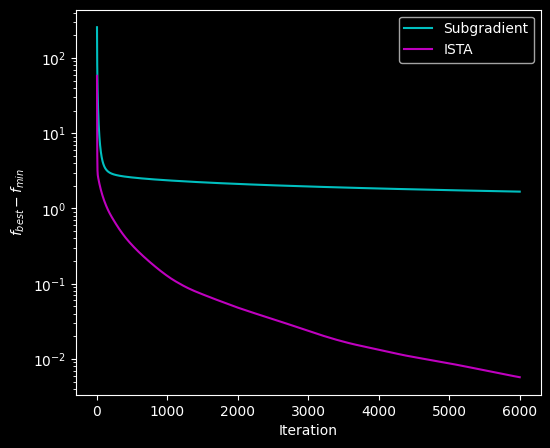

In [ ]:
x1 = np.zeros(n)
Rtrue = np.linalg.norm(x1 - x_var.value)
print(f"Optimal value (CVXPY) {f_min:.4f}")
tol = 1e-4
n_iter = 6000
iters = np.arange(1, n_iter + 1)

fig, ax = plt.subplots(figsize=(6, 5))

x_subgrad, hist_subgrad = subgrad_l1_ls(A, b, x1, lamb=lamb, a=1e-4, tol=tol, n_iter=n_iter)
x_ista, hist_ista = ista_l1_ls(A, b, x1, lamb=lamb, tol=tol, n_iter=n_iter)
print(f"optimal f (subgrad): {hist_subgrad['f_best'][-1]:.4f}")
print(f"optimal f (ista): {hist_ista['f'][-1]:.4f}")

ax.semilogy(iters, np.array(hist_subgrad['f_best'][1:]) - f_min, 'c-', label="Subgradient")
ax.semilogy(iters, np.array(hist_ista['f'][1:]) - f_min, 'm-', label="ISTA")
ax.set_xlabel('Iteration')
ax.set_ylabel('$f_{best} - f_{min}$')
ax.legend()

plt.show()

#### Convergence results

##### Smooth function

Assume

* $g$ is convex, differentiable, unconstrained, and $M$-`smooth` ($\nabla g$ is Lipschitz continuous with constant $M$)
* $h$ is convex and we can evaluate $\text{prox}_{h, t}(x)$

Then, proximal gradient method with fixed step size $t\leq 1/M$ satisfies

$$f(x^k)-f^*\leq \frac{1}{2tk}\|x^0-x^*\|_2^2$$

Same result holds for backtracking with $t$ replaced by $\beta / M$

That is, proximal gradient method has convergence rate $\sim \frac{1}{k}$ and steps for $\epsilon$-suboptimality $\sim \frac{1}{\epsilon}$, which matches gradient descent for smooth function (in terms of steps)

##### Smooth and strongly convex

If $g$ is also $m$-`strongly convex`, with fixed step size $t=1/M$ we have

$$\|x^k-x^*\|_2^2\leq \gamma^k\|x^0-x^*\|_2^2, \gamma = 1-m/M$$

This is also similar to the gradient descent case for smooth and strongly convex functions